First, import the data and perform data preprocessing:
1. Check if there are missing values ​​and process them
2. Encode the target variables in order

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train_data.csv')
df.head()
df.info()

print(df.isnull().sum())

# Deal with Null Data
df['Bed Grade'] = df['Bed Grade'].fillna(df['Bed Grade'].median())
df['City_Code_Patient'] = df['City_Code_Patient'].fillna(df['City_Code_Patient'].mode()[0])
print(df.isnull().sum())


# Encode the target variable
print(df['Stay'].unique())
stay_mapping = {
    '0-10': 1,
    '11-20': 2,
    '21-30': 3,
    '31-40': 4,
    '41-50': 5,
    '51-60': 6,
    '61-70': 7,
    '71-80': 8,
    '81-90': 9,
    '91-100': 10,
    'More than 100 Days': 11
}
df['Stay_number'] = df['Stay'].map(stay_mapping)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

Next, we conduct a correlation analysis. First, we analyze the correlation between the unordered categorical variables and the target variable. Then we use the one-hot encoding method to calculate the dummies variable for each categorical variable and perform an OLS regression analysis with the target variable.

In [16]:
# Encoding columns that have no natural order
categorical_cols = [
    'Hospital_code',
    'Hospital_type_code',
    'City_Code_Hospital',
    'Hospital_region_code',
    'Department',
    'Ward_Type',
    'Ward_Facility_Code',
    'City_Code_Patient',
    'Type of Admission',
]

# One-hot encode
df_onehot = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_onehot.info()

# Prepare X and y
X = df_onehot.drop(['case_id','Available Extra Rooms in Hospital', 'Bed Grade','patientid','Severity of Illness', 'Visitors with Patient','Age','Admission_Deposit','Stay','Stay_number'], axis=1)
y = df_onehot['Stay_number']
df_onehot.head()

X = X.astype(int)
X.info()

# Regression
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# Output Result
result = model.summary()
with open("ols_results.txt", "w", encoding="utf-8") as f:
    f.write(result.as_text())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Columns: 111 entries, case_id to Type of Admission_Urgent
dtypes: bool(101), float64(2), int64(5), object(3)
memory usage: 55.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Columns: 101 entries, Hospital_code_2 to Type of Admission_Urgent
dtypes: int64(101)
memory usage: 245.4 MB
                            OLS Regression Results                            
Dep. Variable:            Stay_number   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     323.1
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:28:07   Log-Likelihood:            -6.8348e+05
No. Observations:              318438   AIC:                         1.367e+06
Df Residuals:                  318359   BIC:       

Since the one-hot method has serious multicollinearity in OLS regression and the regression effect is poor, the method of calculating the correlation ratio should be used. However, this method can only calculate the degree of influence, not the direction of influence.

In [14]:
import numpy as np
import pandas as pd

def correlation_ratio(categories, measurements):
    """
Computes the correlation ratio (η) between an unordered categorical variable and a numerical variable.

Parameters:
categories: Series or array, representing categorical variables (Nominal)
measurements: Series or array, representing numerical variables

Returns:
      η值 (0 <= η <= 1)
    """
    fcat, _ = pd.factorize(categories)

    y_mean = np.mean(measurements)

    ss_total = np.sum((measurements - y_mean) ** 2)
    ss_between = 0.0

    for cat in np.unique(fcat):
        cat_measure = measurements[fcat == cat]
        cat_size = cat_measure.size
        if cat_size > 0:
            cat_mean = np.mean(cat_measure)
            ss_between += cat_size * (cat_mean - y_mean) ** 2

    if ss_total == 0:
        return 0.0

    eta_squared = ss_between / ss_total
    return np.sqrt(eta_squared)


for col in categorical_cols:
  eta_value = correlation_ratio(df[col], df['Stay_number'])
  print(col, "vs Stay_number η:", eta_value)
#eta_value = correlation_ratio(df['Department'], df['Stay_number'])
#print("Department vs Stay_number η:", eta_value)

Hospital_code vs Stay_number η: 0.1542544540281471
Hospital_type_code vs Stay_number η: 0.08193433818910614
City_Code_Hospital vs Stay_number η: 0.08593442639943653
Hospital_region_code vs Stay_number η: 0.012518841476123487
Department vs Stay_number η: 0.037659087896502325
Ward_Type vs Stay_number η: 0.19253833599940784
Ward_Facility_Code vs Stay_number η: 0.08399770552096586
City_Code_Patient vs Stay_number η: 0.08164103890988397
Type of Admission vs Stay_number η: 0.09220529699416978


Next, calculate the correlation between continuous numerical variables, ordinal categorical variables and target variables:
1. Encode ordinal categorical variables, the size of the encoding is related to the order
2. Calculate the spearman correlation coefficient and visualize it

In [5]:
# Encoding columns that have natural order
print(df['Severity of Illness'].unique())
severity_mapping = {
    'Minor': 1,
    'Moderate': 2,
    'Extreme': 3
}
df['Severity_number'] = df['Severity of Illness'].map(severity_mapping)

print(df['Age'].unique())
age_mapping = {
    '0-10': 1,
    '11-20': 2,
    '21-30': 3,
    '31-40': 4,
    '41-50': 5,
    '51-60': 6,
    '61-70': 7,
    '71-80': 8,
    '81-90': 9,
    '91-100': 10
}
df['Age_number'] = df['Age'].map(age_mapping)

# Transform types
df['Bed Grade'] = df['Bed Grade'].astype(int)
df['City_Code_Patient'] = df['City_Code_Patient'].astype(int)

['Extreme' 'Moderate' 'Minor']
['51-60' '71-80' '31-40' '41-50' '81-90' '61-70' '21-30' '11-20' '0-10'
 '91-100']


                                   Available Extra Rooms in Hospital  \
Available Extra Rooms in Hospital                           1.000000   
Bed Grade                                                  -0.131115   
Severity_number                                            -0.001381   
Age_number                                                 -0.162063   
Visitors with Patient                                       0.140427   
Admission_Deposit                                          -0.169828   
Stay_number                                                -0.109428   

                                   Bed Grade  Severity_number  Age_number  \
Available Extra Rooms in Hospital  -0.131115        -0.001381   -0.162063   
Bed Grade                           1.000000        -0.287760    0.000898   
Severity_number                    -0.287760         1.000000    0.130337   
Age_number                          0.000898         0.130337    1.000000   
Visitors with Patient               0.

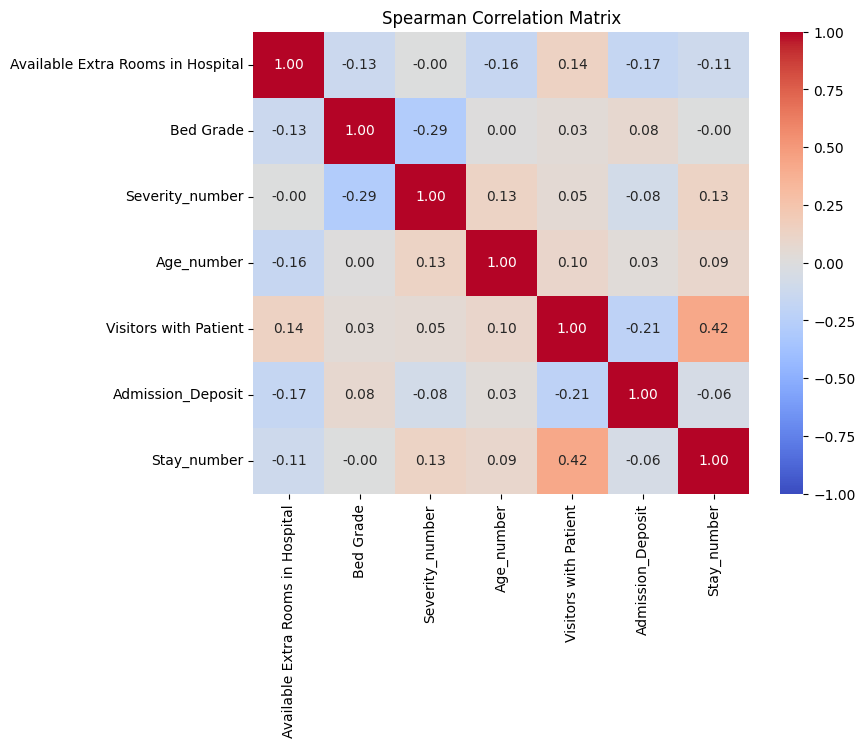

In [6]:
# Compute correlations between numeric and ordinal categorical coded variables and the target variable
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

cols = [
    'Available Extra Rooms in Hospital',
    'Bed Grade',
    'Severity_number',
    'Age_number',
    'Visitors with Patient',
    'Admission_Deposit',
    'Stay_number'
]

# Calculate Spearman corr matrix
corr_matrix = df[cols].corr(method='spearman')
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Spearman Correlation Matrix")
plt.show()

Available Extra Rooms in Hospital Spearman correlation coefficient: -0.10942812757201455
p-value: 0.0
Bed Grade Spearman correlation coefficient: -0.0018071242845944303
p-value: 0.3078410249808393
Severity_number Spearman correlation coefficient: 0.12909213450331894
p-value: 0.0
Age_number Spearman correlation coefficient: 0.09031087349478512
p-value: 0.0
Visitors with Patient Spearman correlation coefficient: 0.42266076801336827
p-value: 0.0
Admission_Deposit Spearman correlation coefficient: -0.05708090920080177
p-value: 5.336009736090509e-228


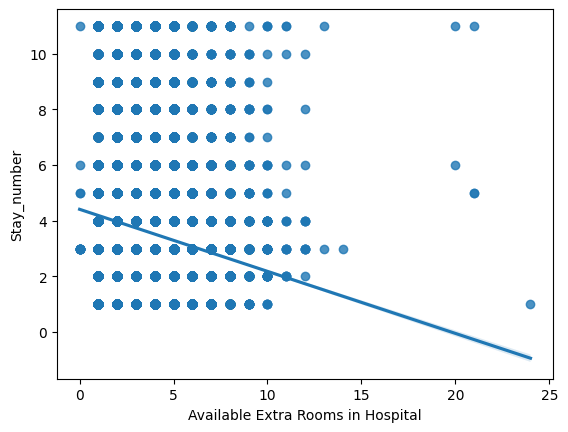

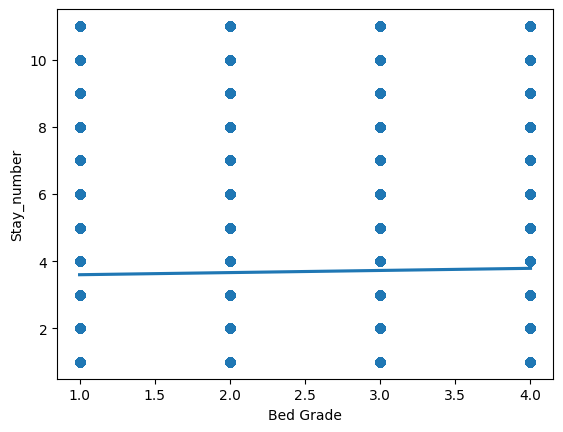

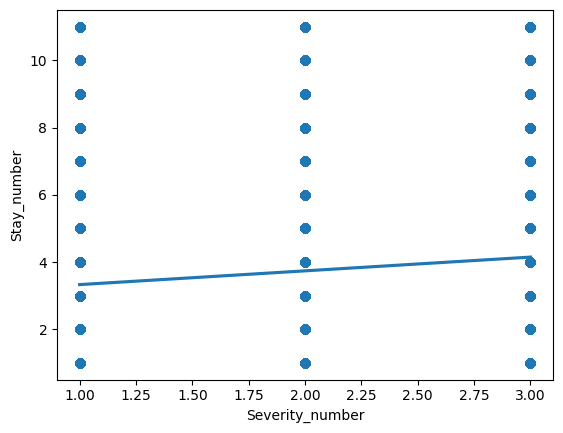

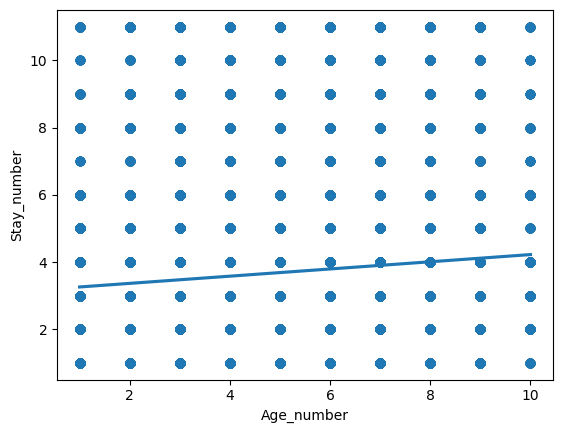

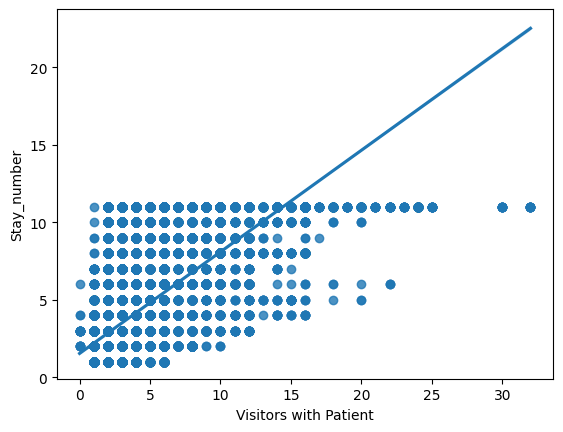

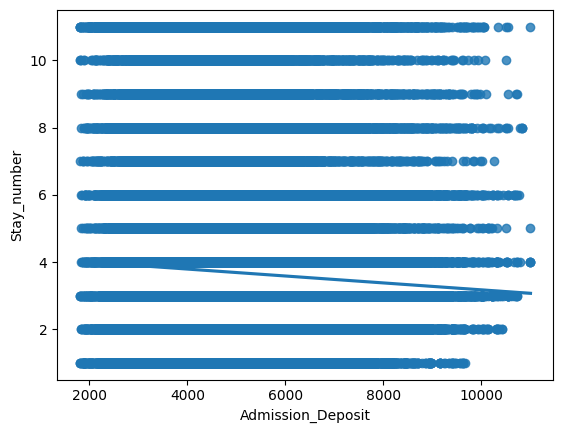

In [ ]:
#Calculate the spearman correlation coefficient and p-value of each variable and the target variable separately
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

cols = [
    'Available Extra Rooms in Hospital',
    'Bed Grade',
    'Severity_number',
    'Age_number',
    'Visitors with Patient',
    'Admission_Deposit',
]

for col in cols:
  x = df[col]
  y = df['Stay_number']
  corr, p_value = spearmanr(x, y)
  print(col, "Spearman correlation coefficient:", corr)
  print("p-value:", p_value)

for col in cols:
  sns.regplot(x=col, y='Stay_number', data=df)
  plt.show()
